In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
%matplotlib inline
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

In [154]:
from sklearn.metrics import accuracy_score

In [2]:
meta_tissue = pd.read_csv('phenotype_prediction/train/tissue/meta.txt', sep='\t')

In [3]:
meta_tissue.head()

,sample,gpl,tissue
0,1,GPL6885,muscle
1,2,GPL7202,brain
2,3,GPL1261,muscle
3,4,GPL6887,brain
4,5,GPL6246,liver


In [4]:
meta_tissue['gpl'].unique()

array(['GPL6885', 'GPL7202', 'GPL1261', 'GPL6887', 'GPL6246', 'GPL81',
       'GPL4134', 'GPL8321', 'GPL339', 'GPL16570'], dtype=object)

# Research

In [419]:
meta_gender = pd.read_csv('phenotype_prediction/train/tissue/meta.txt', sep='\t')

In [420]:
df_train = pd.read_csv('data/train_tissue.csv').drop('Unnamed: 0', axis=1)
df_test = pd.read_csv('data/test_tissue.csv').drop('Unnamed: 0', axis=1)

In [421]:
df_train.isnull().sum(axis=0)

gene_sym          0
expression    67606
gpl               0
tissue            0
sample            0
dtype: int64

In [422]:
df_test.isnull().sum(axis=0)

gene_sym          0
expression    42042
gpl               0
sample            0
dtype: int64

In [423]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [424]:
df_train['expression'] = df_train.groupby('sample').expression.transform(lambda x: x / x.max())
df_test['expression'] = df_test.groupby('sample').expression.transform(lambda x: x / x.max())

In [425]:
df_concat = pd.concat([df_train, df_test], keys=["train", "test"])

In [426]:
df_concat.head()

expression gene_sym      gpl  sample  tissue
train 0    0.543810    cradd  GPL6885       1  muscle
      1    0.666459    rcan2  GPL6885       1  muscle
      2    0.538877   mfap3l  GPL6885       1  muscle
      3    0.537864  tcerg1l  GPL6885       1  muscle
      4    0.550665   mb21d2  GPL6885       1  muscle

In [427]:
categories = ['tissue', 'gene_sym', 'gpl']

df_fact = df_concat.copy()

for category in categories:
    tmp = pd.factorize(df_concat[category])
    if category == 'tissue':
        print(tmp[1])
    df_fact[category] = tmp[0]

Index(['muscle', 'brain', 'liver', 'lung'], dtype='object')


In [428]:
df_train = df_fact.ix['train']
df_test = df_fact.ix['test'].drop('tissue', axis=1)

In [429]:
df_train.head()

,expression,gene_sym,gpl,sample,tissue
0,0.543810,0,0,1,0
1,0.666459,1,0,1,0
2,0.538877,2,0,1,0
3,0.537864,3,0,1,0
4,0.550665,4,0,1,0


In [430]:
def only_sample(df_, sam):
    return df_[df_['sample'] == sam]

def make_prediction(df_, clf_):
    x_ = df_.drop(['tissue', 'sample'], axis=1)
    predictions_ = clf_.predict(x_)
    
    def most_common(pred):
        return Counter(pred).most_common(1)[0][0]
    return most_common(predictions_)

In [431]:
tmp_train = df_train.sample(300000)
# X_train, X_valid, Y_train, Y_valid = train_test_split(tmp_train.drop(['gender', 'sample'], axis=1), tmp_train['gender'],
#                                                       test_size=0.3, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(tmp_train, tmp_train['tissue'],
                                                      test_size=0.3, random_state=42)

In [432]:
len(X_train)

210000

In [433]:
clasxgb = XGBClassifier(n_estimators=300, learning_rate=0.1, seed=42)
clasxgb.fit(X_train.drop(['tissue', 'sample'], axis=1), Y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=1)

In [438]:
print(accuracy_score(Y_valid, clasxgb.predict(X_valid.drop(['tissue', 'sample'], axis=1))))

0.528766666667


In [439]:
meta_gender_dict = dict(meta_gender[['sample', 'tissue']].values)

In [440]:
samples = X_valid['sample'].unique()

predictions = []

for i in tqdm.tqdm(samples):
    predictions.append(make_prediction(only_sample(X_valid, i), clasxgb))

100%|██████████| 189/189 [00:02<00:00, 73.73it/s]


In [441]:
answers = list(map(lambda x: meta_gender_dict[x], samples))

In [442]:
gender_dict = {0:'muscle', 1:'brain', 2:'liver', 3:'lung'}

In [443]:
predictions = list(map(lambda x: gender_dict[x], predictions))

In [444]:
accuracy_score(answers, predictions)

0.59259259259259256

# Sex Genes

In [436]:
sex_genes = pd.read_csv('sex_genes.txt', sep='\t')

In [437]:
sex_genes

,Symbol,Chromosome
0,B430216B18Rik,X
1,Ssxb2,X
2,Agtr2,X
3,Magea4,X
4,Magea9,X
5,Arx,X
6,Xmr,X
7,Ssxb5,X
8,Cetn2,X
9,Prkx,X


# Test Prediction

In [413]:
df_test['sample'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

In [445]:
def only_sample(df_, sam):
    return df_[df_['sample'] == sam]

def make_prediction(df_, clf_):
    x_ = df_.drop(['sample'], axis=1)
    predictions_ = clf_.predict(x_)
    
    def most_common(pred):
        return Counter(pred).most_common(1)[0][0]
    return most_common(predictions_)

samples = sorted(df_test['sample'].unique())

predictions = []

for i in tqdm.tqdm(samples):
    predictions.append(make_prediction(only_sample(df_test, i), clasxgb))

100%|██████████| 190/190 [02:20<00:00,  1.58it/s]


In [446]:
predictions = list(map(lambda x: gender_dict[x], predictions))

In [447]:
to_dump = pd.DataFrame(data={'tissue': predictions, 'sample': samples})

In [448]:
to_dump.to_csv('data/tissue_out.txt', sep='\t', index=False)

In [199]:
unique_genes = df_train['gene_sym'].unique()

In [198]:
len(list(df_train['gene_sym'].unique())), len(df_train['gene_sym'])

(26758, 2946127)

In [201]:
df_train.values[:100]

array([[  4.56776,   0.     ,   0.     ,   0.     ,   1.     ],
       [  1.83509,   0.     ,   1.     ,   0.     ,   1.     ],
       [  7.5798 ,   0.     ,   2.     ,   0.     ,   1.     ],
       [  8.45065,   0.     ,   3.     ,   0.     ,   1.     ],
       [  6.853  ,   0.     ,   4.     ,   0.     ,   1.     ],
       [  2.58946,   0.     ,   5.     ,   0.     ,   1.     ],
       [  6.74641,   0.     ,   6.     ,   0.     ,   1.     ],
       [  1.59195,   0.     ,   7.     ,   0.     ,   1.     ],
       [  3.75153,   0.     ,   8.     ,   0.     ,   1.     ],
       [  6.54191,   0.     ,   9.     ,   0.     ,   1.     ],
       [  2.69599,   0.     ,  10.     ,   0.     ,   1.     ],
       [  6.12814,   0.     ,  11.     ,   0.     ,   1.     ],
       [  5.62937,   0.     ,  12.     ,   0.     ,   1.     ],
       [  2.85601,   0.     ,  13.     ,   0.     ,   1.     ],
       [  7.50191,   0.     ,  14.     ,   0.     ,   1.     ],
       [  2.60447,   0.     ,  15.     ,

In [ ]:
tmp_dict = {}
for row in tqdm.tqdm(df_train.values[:100]):
    if row[1] in tmp_dict:
        tmp_dict[row[1]][row[0]] = row[2]
    else:
        tmp_dict[row[1]] = {row[0]: row[2]}

In [4]:
df_result.fillna(0, inplace=True)

In [184]:
df_result['concated'] = list(map(lambda x: str(x[0])+'_'+str(x[1]), df_result[['sample', 'gene_sym']].values))

In [222]:
len(df_result)

2973905

In [5]:
df_res_dropped = df_result.drop_duplicates(['gene_sym', 'sample'])

In [6]:
len(df_res_dropped)

1849175

In [6]:
short = df_res_dropped[['gene_sym', 'sample', 'expression']]

In [80]:
df_res_dropped

,gene_sym,expression,gpl,gender,sample
0,gm2889,4.56776,GPL6246,male,1
1,gm10568,1.83509,GPL6246,male,1
2,lypla1,7.57980,GPL6246,male,1
3,tcea1,8.45065,GPL6246,male,1
4,atp6v1h,6.85300,GPL6246,male,1
5,oprk1,2.58946,GPL6246,male,1
6,rb1cc1,6.74641,GPL6246,male,1
7,fam150a,1.59195,GPL6246,male,1
8,st18,3.75153,GPL6246,male,1
9,pcmtd1,6.54191,GPL6246,male,1


In [7]:
tmp_dict = {}
for row in tqdm.tqdm(short.values):
    if row[1] in tmp_dict:
        tmp_dict[row[1]][row[0]] = row[2]
    else:
        tmp_dict[row[1]] = {row[0]: row[2]}

100%|██████████| 1849175/1849175 [00:03<00:00, 551902.25it/s]


In [106]:
matrix = pd.DataFrame(tmp_dict)

# for i in matrix:
#     if max(matrix[i]) <= 20:
#         matrix[i] = np.exp(matrix[1])

In [107]:
matrix.shape

(26758, 96)

In [108]:
matrix.fillna(0, inplace=True)

In [109]:
rank_mean = matrix.stack().groupby(matrix.rank(method='first').stack().astype(int)).mean()

In [110]:
normalized = matrix.rank(method='min').stack().astype(int).map(rank_mean).unstack()

In [111]:
normalized.fillna(0, inplace=True)

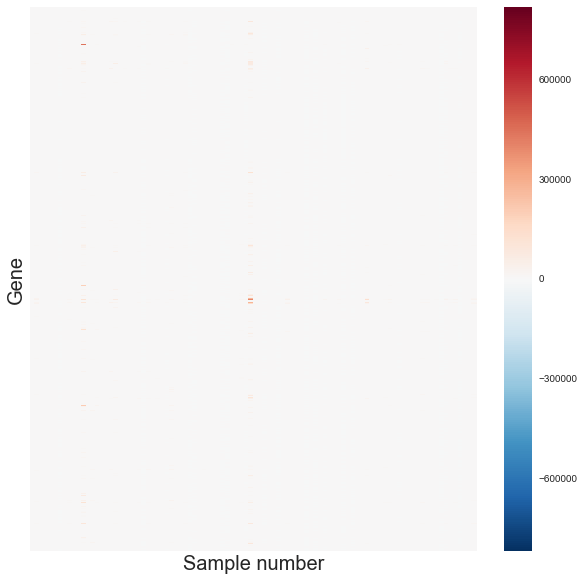

In [128]:
plt.figure(figsize=(10,10))
sns.heatmap(matrix.iloc[list(range(16000,26000))], yticklabels=False, xticklabels=False)
plt.xlabel('Sample number', fontsize=20)
plt.ylabel('Gene', fontsize=20)
plt.show()

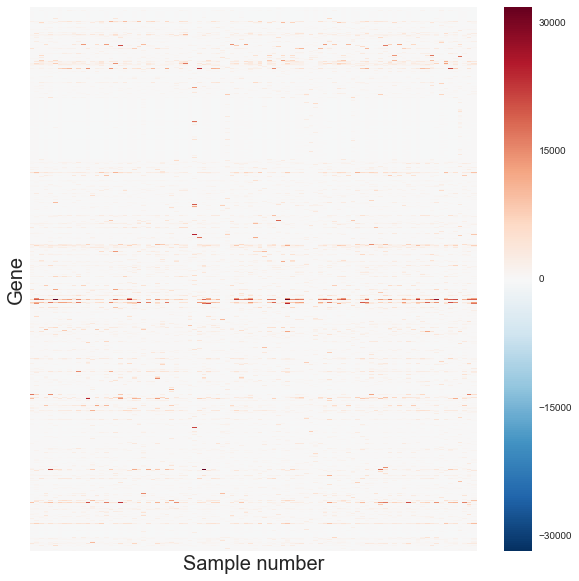

In [127]:
plt.figure(figsize=(10,10))
sns.heatmap(normalized.iloc[list(range(16000,26000))], yticklabels=False, xticklabels=False)
plt.xlabel('Sample number', fontsize=20)
plt.ylabel('Gene', fontsize=20)
plt.show()

In [117]:
norm_dict = normalized.to_dict()

In [120]:
list(norm_dict.items())[:10]

[(1,
  {'0610005c13rik': -18.775734626398645,
   '0610006l08rik': -18.775734626398645,
   '0610007p14rik': 356.66541541358293,
   '0610009b22rik': 67.295230255281979,
   '0610009k14rik': -18.775734626398645,
   '0610009l18rik': 95.802659342998368,
   '0610009o20rik': 199.64885743203831,
   '0610010f05rik': 41.676546352839118,
   '0610010k14rik': -18.775734626398645,
   '0610011f06rik': 117.12455998251056,
   '0610012e21rik': -18.775734626398645,
   '0610012g03rik': 155.21032610090342,
   '0610025j13rik': 30.429263663559414,
   '0610030e20rik': 134.75220225915857,
   '0610033m10rik': -18.775734626398645,
   '0610037l13rik': 119.16827100077147,
   '0610037l18rik': -18.775734626398645,
   '0610038b21rik': 23.770545962995893,
   '0610039h22rik': -18.775734626398645,
   '0610039k10rik': 19.200928127631496,
   '0610040a22rik': -18.775734626398645,
   '0610040b10rik': 18.961750764068533,
   '0610040f04rik': -18.775734626398645,
   '0610040j01rik': 74.617297115351306,
   '0610042e11rik': -18.7

In [134]:
df_res_dropped['expression'] = list(map(lambda x: norm_dict[x[0]][x[1]], df_res_dropped[['sample', 'gene_sym']].values))

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


(array([  1.81204500e+06,   2.26410000e+04,   7.04200000e+03,
          3.03700000e+03,   2.01300000e+03,   1.05400000e+03,
          7.68000000e+02,   2.87000000e+02,   1.92000000e+02,
          9.60000000e+01]),
 array([ -1.87757346e+01,   3.15818411e+03,   6.33514396e+03,
          9.51210381e+03,   1.26890637e+04,   1.58660235e+04,
          1.90429834e+04,   2.22199432e+04,   2.53969031e+04,
          2.85738629e+04,   3.17508228e+04]),
 <a list of 10 Patch objects>)

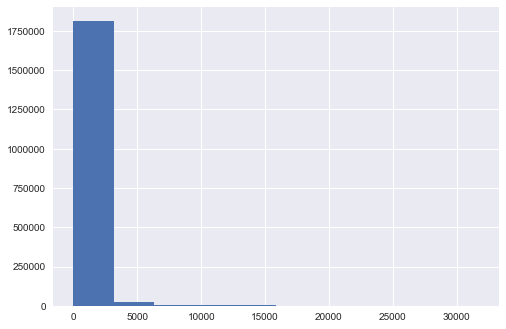

In [137]:
plt.hist(df_res_dropped['expression'])

# XGBoost

In [138]:
from xgboost import XGBClassifier

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [142]:
categories = ['gene_sym', 'gpl', 'gender']

df_fact = df_res_dropped.copy()

for category in categories:
    df_fact[category] = pd.factorize(df_fact[category], na_sentinel=9999)[0]

In [143]:
df_fact.head()

,gene_sym,expression,gpl,gender,sample
0,0,30.484906,0,0,1
1,1,3.610821,0,0,1
2,2,736.314916,0,0,1
3,3,1809.745339,0,0,1
4,4,311.572700,0,0,1


In [160]:
sampled = df_fact.sample(100000, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(sampled.drop(['gender', 'sample'], axis=1), sampled['gender'],
                                                      test_size=0.3, random_state=42)

(array([ 52743.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  47257.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

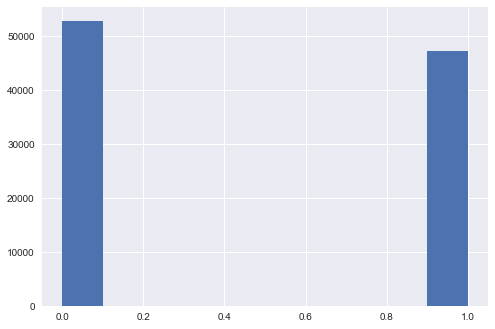

In [161]:
plt.hist(sampled['gender'])

In [162]:
len(X_train)

70000

In [166]:
%%time
xgbclf = XGBClassifier(n_estimators=300, learning_rate=0.1, seed=42, nthread=20)
xgbclf.fit(X_train, Y_train)

CPU times: user 8.57 s, sys: 2.14 s, total: 10.7 s
Wall time: 3.92 s


In [167]:
predictions = xgbclf.predict(X_valid)

In [173]:
accuracy_score(Y_valid, predictions)

0.67846666666666666

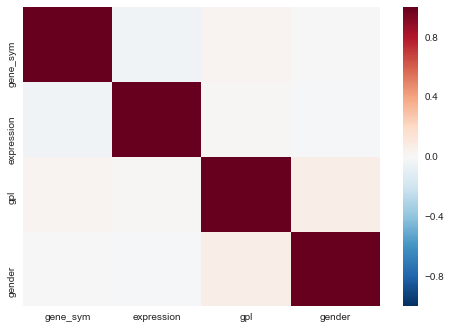

In [172]:
sns.heatmap(df_fact.drop('sample', axis=1).corr())

In [228]:
short['expression'], short['gene_sym']

,gene_sym,sample,expression
0,gm2889,1,4.56776
1,gm10568,1,1.83509
2,lypla1,1,7.57980
3,tcea1,1,8.45065
4,atp6v1h,1,6.85300
5,oprk1,1,2.58946
6,rb1cc1,1,6.74641
7,fam150a,1,1.59195
8,st18,1,3.75153
9,pcmtd1,1,6.54191


In [221]:
df_result.head()

,gene_sym,expression,gpl,gender,sample
0,gm2889,4.56776,GPL6246,male,1
1,gm10568,1.83509,GPL6246,male,1
2,lypla1,7.57980,GPL6246,male,1
3,tcea1,8.45065,GPL6246,male,1
4,atp6v1h,6.85300,GPL6246,male,1


In [209]:
df_result[(df_result['gene_sym'] == '0610005c13rik') & (df_result['sample'] == 3)]

,gene_sym,expression,gpl,gender,sample
77763,0610005c13rik,4.353746,GPL1261,male,3


In [210]:
asdasfasf = df_result.groupby(['gene_sym', 'sample']).mean()

In [211]:
asdasfasf[asdasfasf['gene_sym'] == 'hmcn1']

KeyError: 'gene_sym'

In [198]:
df_result.groupby('concated').mean()

,expression,sample
concated,,
10_0610005c13rik,13.194771,10
10_0610007p14rik,15.598761,10
10_0610009b22rik,12.242228,10
10_0610009k14rik,0.000000,10
10_0610009l18rik,10.038634,10
10_0610009o20rik,5.531166,10
10_0610010f05rik,5.770757,10
10_0610010k14rik,10.498174,10
10_0610011f06rik,14.563860,10


In [169]:
df_result['expression'] = df_result.groupby('sample').expression.transform(lambda x: x / x.max())

In [178]:
df_result.drop('sample', axis=1, inplace=True)
df_result.head()

,gene_sym,expression,gpl,gender
0,gm2889,0.355861,GPL6246,male
1,gm10568,0.142967,GPL6246,male
2,lypla1,0.590520,GPL6246,male
3,tcea1,0.658366,GPL6246,male
4,atp6v1h,0.533897,GPL6246,male


In [187]:
categories = ['gene_sym', 'gpl', 'gender', 'concated']

df_fact = df_result.copy()

for category in categories:
    df_fact[category] = pd.factorize(df_fact[category], na_sentinel=9999)[0]

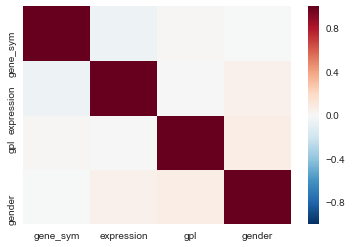

In [180]:
sns.heatmap(df_fact.corr())

In [135]:
tmp = df_result[['gene_sym', 'sample', 'expression']]
tmp['concated'] = list(map(lambda x: str(x[0])+'_'+str(x[1]), tmp[['sample', 'gene_sym']].values))

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [128]:
tmp_counter = Counter(tmp['concated'].values)
tmp_filter = list(filter(lambda x: x[1] > 1, list(dict(tmp_counter).items())))
sorted(tmp_filter, key=lambda x: x[1], reverse=True)[:20]

[('1_snord115', 79),
 ('17_snord115', 79),
 ('20_snord115', 79),
 ('46_snord115', 79),
 ('75_snord115', 79),
 ('95_snord115', 79),
 ('4_snord115', 79),
 ('13_snord115', 79),
 ('29_snord115', 79),
 ('32_snord115', 79),
 ('38_snord115', 79),
 ('71_snord115', 79),
 ('82_snord115', 79),
 ('1_hmcn1', 77),
 ('17_hmcn1', 77),
 ('20_hmcn1', 77),
 ('23_hmcn1', 77),
 ('28_hmcn1', 77),
 ('46_hmcn1', 77),
 ('75_hmcn1', 77)]

In [129]:
len(tmp_filter)

650729

In [137]:
tmp

,gene_sym,sample,expression,concated
0,gm2889,1,4.56776,1_gm2889
1,gm10568,1,1.83509,1_gm10568
2,lypla1,1,7.57980,1_lypla1
3,tcea1,1,8.45065,1_tcea1
4,atp6v1h,1,6.85300,1_atp6v1h
5,oprk1,1,2.58946,1_oprk1
6,rb1cc1,1,6.74641,1_rb1cc1
7,fam150a,1,1.59195,1_fam150a
8,st18,1,3.75153,1_st18
9,pcmtd1,1,6.54191,1_pcmtd1


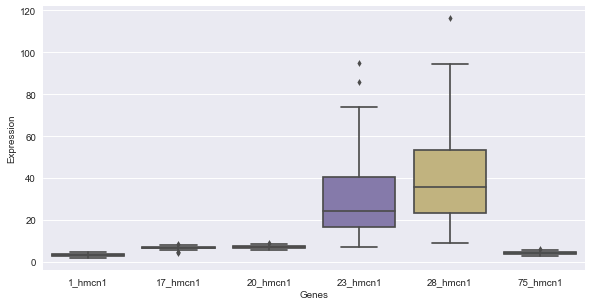

In [138]:
plt.figure(figsize=(10,5), dpi=70)
sns.boxplot(x="concated", y="expression",
              data=tmp[tmp['concated'].isin(['1_hmcn1', '17_hmcn1', '20_hmcn1', '23_hmcn1', '28_hmcn1', '75_hmcn1'])])
plt.ylabel('Expression', fontsize=10)
plt.xlabel('Genes', fontsize=10);

In [139]:
tmp.head()

,gene_sym,sample,expression,concated
0,gm2889,1,4.56776,1_gm2889
1,gm10568,1,1.83509,1_gm10568
2,lypla1,1,7.57980,1_lypla1
3,tcea1,1,8.45065,1_tcea1
4,atp6v1h,1,6.85300,1_atp6v1h


In [141]:
tmp.corr()

,sample,expression
sample,1.000000,-0.027657
expression,-0.027657,1.000000


In [ ]:
import pandas.rpy.common as com
import seaborn as sns
%matplotlib inline

# load the R package ISLR
infert = com.importr("ISLR")

# load the Auto dataset
auto_df = com.load_data('Auto')

# calculate the correlation matrix
corr = auto_df.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [132]:
# tmp['expr_max'] = tmp.groupby(['concated'])['expression'].transform(np.max)
# tmp['expression'] = tmp['expression'] / tmp['expr_max']

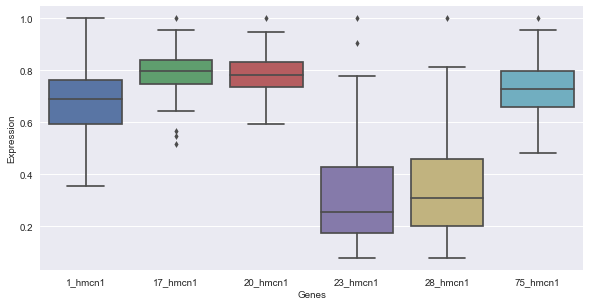

In [134]:
# plt.figure(figsize=(10,5), dpi=70)
# sns.boxplot(x="concated", y="expression",
#               data=tmp[tmp['concated'].isin(['1_hmcn1', '17_hmcn1', '20_hmcn1', '23_hmcn1', '28_hmcn1', '75_hmcn1'])])
# plt.ylabel('Expression', fontsize=10)
# plt.xlabel('Genes', fontsize=10);

# Prepare Train Dataset

In [12]:
def gene_expr_id(df_in, gpl):
    df_ = df_in.copy()
    gene_id = dict(gpl[['ID', 'Gene ID']].values)
    
    df_['gene_id'] = list(map(lambda x: gene_id[x], df_['id']))
    
    return df_.loc[list(map(lambda x: '/' not in str(x) and not pd.isnull(x),
                            df_['gene_id']))][['gene_id', 'expression']]

def gene_expr_sym(df_in, gpl):
    df_ = df_in.copy()
    gene_sym = dict(gpl[['ID', 'Gene symbol']].values)
    
    df_['gene_sym'] = list(map(lambda x: np.nan if pd.isnull(gene_sym[x]) else
                               str(gene_sym[x]).lower(), df_['id']))

    return df_.loc[list(map(lambda x: '/' not in str(x) and not pd.isnull(x),
                            df_['gene_sym']))][['gene_sym', 'expression']]

In [281]:
meta_tissue['tissue'].unique()

array(['muscle', 'brain', 'liver', 'lung'], dtype=object)

In [288]:
df_result = pd.DataFrame()

for tissue in meta_tissue['tissue'].unique():
    brain_table = meta_tissue.loc[meta_tissue['tissue'] == tissue]

    for sample in tqdm.tqdm(brain_table.values):
        if sample[1] == 'GPL16570':
            continue

        gpl = pd.read_csv('phenotype_prediction/annotation/{}.tsv'.format(sample[1]), sep='\t')

        rec = pd.read_csv('phenotype_prediction/train/tissue/{}'.format(sample[0]), sep='\t',
                                names=['id', 'expression'], header=None)

        tmp = gene_expr_sym(rec, gpl)
        tmp['gpl'] = sample[1]
        tmp['tissue'] = tissue
        tmp['sample'] = sample[0]
        
        df_result = df_result.append(tmp, ignore_index=True)


100%|██████████| 38/38 [01:06<00:00,  1.97s/it]


In [289]:
len(df_result)

5808013

In [291]:
df_result

,gene_sym,expression,gpl,tissue,sample
0,cradd,8.30550,GPL6885,muscle,1
1,rcan2,10.17869,GPL6885,muscle,1
2,mfap3l,8.23015,GPL6885,muscle,1
3,tcerg1l,8.21468,GPL6885,muscle,1
4,mb21d2,8.41019,GPL6885,muscle,1
5,strap,11.83035,GPL6885,muscle,1
6,lman1,9.80044,GPL6885,muscle,1
7,slc6a13,8.45502,GPL6885,muscle,1
8,pramef8,8.24941,GPL6885,muscle,1
9,rftn2,8.84309,GPL6885,muscle,1


In [292]:
df_result.to_csv('data/train_tissue.csv')

# Gender Dataset

In [45]:
meta = pd.read_csv('phenotype_prediction/train/gender/meta.txt', sep='\t')

def gene_expr_id(df_in, gpl):
    df_ = df_in.copy()
    gene_id = dict(gpl[['ID', 'Gene ID']].values)
    
    df_['gene_id'] = list(map(lambda x: gene_id[x], df_['id']))
    
    return df_.loc[list(map(lambda x: '/' not in str(x) and not pd.isnull(x),
                            df_['gene_id']))][['gene_id', 'expression']]

def gene_expr_sym(df_in, gpl):
    df_ = df_in.copy()
    gene_sym = dict(gpl[['ID', 'Gene symbol']].values)
    
    df_['gene_sym'] = list(map(lambda x: np.nan if pd.isnull(gene_sym[x]) else
                               str(gene_sym[x]).lower(), df_['id']))

    return df_.loc[list(map(lambda x: '/' not in str(x) and not pd.isnull(x),
                            df_['gene_sym']))][['gene_sym', 'expression']]

df_train = pd.DataFrame()

for gender in meta['gender'].unique():
    table = meta.loc[meta['gender'] == gender]

    for sample in tqdm.tqdm(table.values):
        if sample[1] == 'GPL16570':
            continue

        gpl = pd.read_csv('phenotype_prediction/annotation/{}.tsv'.format(sample[1]), sep='\t')

        rec = pd.read_csv('phenotype_prediction/train/gender/{}'.format(sample[0]), sep='\t',
                                names=['id', 'expression'], header=None)

        tmp = gene_expr_sym(rec, gpl)
        tmp['gpl'] = sample[1]
        tmp['gender'] = gender
        tmp['sample'] = sample[0]
        
        df_train = df_train.append(tmp, ignore_index=True)

In [48]:
df_train.to_csv('data/train_gender.csv')

In [50]:
df_train.head()

,gene_sym,expression,gpl,gender,sample
0,gm2889,4.56776,GPL6246,male,1
1,gm10568,1.83509,GPL6246,male,1
2,lypla1,7.57980,GPL6246,male,1
3,tcea1,8.45065,GPL6246,male,1
4,atp6v1h,6.85300,GPL6246,male,1


In [64]:
meta = pd.read_csv('phenotype_prediction/test/gender/meta.txt', sep='\t')

def gene_expr_id(df_in, gpl):
    df_ = df_in.copy()
    gene_id = dict(gpl[['ID', 'Gene ID']].values)
    
    df_['gene_id'] = list(map(lambda x: gene_id[x], df_['id']))
    
    return df_.loc[list(map(lambda x: '/' not in str(x) and not pd.isnull(x),
                            df_['gene_id']))][['gene_id', 'expression']]

def gene_expr_sym(df_in, gpl):
    df_ = df_in.copy()
    gene_sym = dict(gpl[['ID', 'Gene symbol']].values)
    
    df_['gene_sym'] = list(map(lambda x: np.nan if pd.isnull(gene_sym[x]) else
                               str(gene_sym[x]).lower(), df_['id']))

    return df_.loc[list(map(lambda x: '/' not in str(x) and not pd.isnull(x),
                            df_['gene_sym']))][['gene_sym', 'expression']]

df_test = pd.DataFrame()

for sample in tqdm.tqdm(meta.values):
    if sample[1] == 'GPL16570':
        continue
        
    gpl = pd.read_csv('phenotype_prediction/annotation/{}.tsv'.format(sample[1]), sep='\t')

    rec = pd.read_csv('phenotype_prediction/test/gender/{}'.format(sample[0]), sep='\t',
                            names=['id', 'expression'], header=None)

    tmp = gene_expr_sym(rec, gpl)
    tmp['gpl'] = sample[1]
    tmp['sample'] = sample[0]

    df_test = df_test.append(tmp, ignore_index=True)

100%|██████████| 98/98 [01:01<00:00,  1.09it/s]


In [65]:
df_test.to_csv('data/test_gender.csv')

# Fast Prediction

In [13]:
small = pd.DataFrame()

for tissue in meta_tissue['tissue'].unique():
    brain_table = meta_tissue.loc[meta_tissue['tissue'] == tissue]

    for sample in tqdm.tqdm(brain_table.values[:4]):
        if sample[1] == 'GPL16570':
            continue

        gpl = pd.read_csv('phenotype_prediction/annotation/{}.tsv'.format(sample[1]), sep='\t')

        rec = pd.read_csv('phenotype_prediction/train/tissue/{}'.format(sample[0]), sep='\t',
                                names=['id', 'expression'], header=None)

        tmp = gene_expr_sym(rec, gpl)
        tmp['expression'] = tmp['expression'] / max(tmp['expression'])
        tmp['gpl'] = sample[1]
        tmp['tissue'] = tissue
        tmp['sample'] = sample[0]
        
        small = small.append(tmp, ignore_index=True)

100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


In [14]:
small.head()

,gene_sym,expression,gpl,tissue,sample
0,cradd,0.543810,GPL6885,muscle,1
1,rcan2,0.666459,GPL6885,muscle,1
2,mfap3l,0.538877,GPL6885,muscle,1
3,tcerg1l,0.537864,GPL6885,muscle,1
4,mb21d2,0.550665,GPL6885,muscle,1


# It's Predict Time

In [17]:
from catboost import Pool, CatBoostClassifier, cv, CatboostIpythonWidget

In [18]:
small.head()

,gene_sym,expression,gpl,tissue,sample
0,cradd,0.543810,GPL6885,muscle,1
1,rcan2,0.666459,GPL6885,muscle,1
2,mfap3l,0.538877,GPL6885,muscle,1
3,tcerg1l,0.537864,GPL6885,muscle,1
4,mb21d2,0.550665,GPL6885,muscle,1


In [19]:
small.fillna(0, inplace=True)

In [20]:
X = small.drop(['tissue', 'sample'], axis=1)
y = small.tissue

In [21]:
keks = dict(enumerate(y.unique()))
keks = dict(zip(keks.values(), keks.keys()))
keks

{'brain': 1, 'liver': 2, 'lung': 3, 'muscle': 0}

In [22]:
y = list(map(lambda i: keks[i], y))

In [23]:
X.dtypes

gene_sym       object
expression    float64
gpl            object
dtype: object

In [24]:
categorical_features_indices = np.where(X.dtypes == np.object)[0]
categorical_features_indices

array([0, 2])

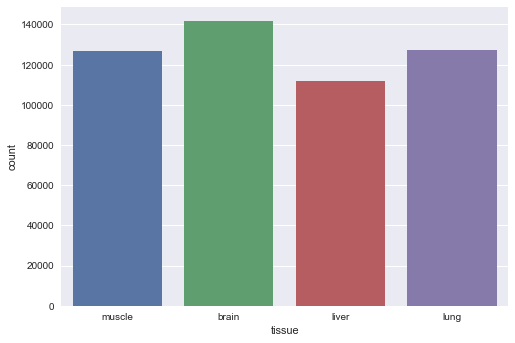

In [28]:
sns.countplot(x='tissue', data=small);

In [29]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85, random_state=1234)

In [30]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    use_best_model=True
)

model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    plot=True
)

In [33]:
df_test_tissue = pd.read_csv('data/test_tissue.csv').drop('Unnamed: 0', axis=1)
df_test_tissue['expression'] = df_test_tissue.groupby('sample').expression.transform(lambda x: x / x.max())

In [39]:
len(df_test_tissue.drop('sample', axis=1))

5861222

In [41]:
predictions = []
for i in tqdm.tqdm(df_test_tissue.drop('sample', axis=1).values[:1000000]):
    predictions.append(model.predict([i]))


  0%|          | 1859/1000000 [01:07<8:12:05, 33.81it/s] 

KeyboardInterrupt: 

In [503]:
keks_rev = dict(zip(keks.values(), keks.keys()))

In [504]:
list(map(lambda x: keks_rev[x], model.predict([['cradd', 0.5438102664935484, 'GPL6885']])))

['muscle']

In [496]:
small.values[0]

array(['cradd', 0.5438102664935484, 'GPL6885', 'muscle', 1], dtype=object)

In [513]:
# X_test = df_test_tissue.drop(['sample'], axis=1)
X_test = df_test_tissue.copy()

In [508]:
X_test['expression'] = X_test['expression'] / max(X_test['expression'])

In [516]:
X_test['sample'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

In [526]:
X_test['expression'] = X_test.groupby('sample').expression.transform(lambda x: x / x.max())

In [528]:
X_test = X_test.drop('sample', axis=1)

In [529]:
X_test.head()

,gene_sym,expression,gpl
0,hivep3,0.360187,GPL7202
1,mif4gd,0.653636,GPL7202
2,slitrk2,0.269626,GPL7202
3,lnx1,0.451056,GPL7202
4,2610002j23rik,0.547684,GPL7202


In [ ]:
predictions = list(map(lambda x: keks_rev[x], model.predict(X_test)))

In [ ]:
"test"

# Prepare Test Dataset

In [293]:
meta_tissue_test = pd.read_csv('phenotype_prediction/test/tissue/meta.txt', sep='\t')

In [300]:
df_test_tissue = pd.DataFrame()

for sample in tqdm.tqdm(meta_tissue_test.values):
    if sample[1] == 'GPL16570':
        continue

    gpl = pd.read_csv('phenotype_prediction/annotation/{}.tsv'.format(sample[1]), sep='\t')

    rec = pd.read_csv('phenotype_prediction/test/tissue/{}'.format(sample[0]), sep='\t',
                            names=['id', 'expression'], header=None)

    tmp = gene_expr_sym(rec, gpl)
    tmp['gpl'] = sample[1]
    tmp['sample'] = sample[0]

    df_test_tissue = df_test_tissue.append(tmp, ignore_index=True)

100%|██████████| 192/192 [02:56<00:00,  1.45s/it]


In [301]:
df_test_tissue

,gene_sym,expression,gpl,sample
0,hivep3,6.933931,GPL7202,1
1,mif4gd,12.583097,GPL7202,1
2,slitrk2,5.190559,GPL7202,1
3,lnx1,8.683247,GPL7202,1
4,2610002j23rik,10.543419,GPL7202,1
5,rpf1,10.897588,GPL7202,1
6,mns1,9.971659,GPL7202,1
7,med14,8.716374,GPL7202,1
8,vmn1r234,5.328797,GPL7202,1
9,ipo5,9.718997,GPL7202,1


In [302]:
df_test_tissue.to_csv('data/test_tissue.csv')